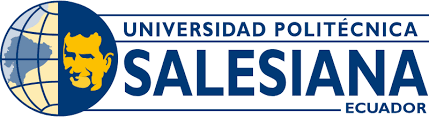


### **Integrantes:** Diego Bravo & Ariel Paltán

### **Carrera:** Computación


## **Modulos Importados**

---



In [2]:
import kagglehub
import os
from kagglehub import dataset_download
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from google.colab import files

print("Modulo importados")

Modulo importados


## **Visualización Dataset (Dimensiones)**

---



In [3]:
path = dataset_download("rabieelkharoua/alzheimers-disease-dataset")

print("Dataset descargado en:", path)

data = pd.read_csv(path + "/alzheimers_disease_data.csv")

print("Dimensiones iniciales:", data.shape)
data.head()

Using Colab cache for faster access to the 'alzheimers-disease-dataset' dataset.
Dataset descargado en: /kaggle/input/alzheimers-disease-dataset
Dimensiones iniciales: (2149, 35)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


## **Limpieza de datos**

---



In [4]:
#En este caso no existia valores nulos, pero se ajusta al procedimiento de la Fase 1, de limpieza de datos
data = data.drop_duplicates()

# Revisar nulos
print(data.isnull().sum())

# Relleno básico (ajusta si necesitas otra estrategia)
data = data.fillna(method="ffill").fillna(method="bfill")


PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

/tmp/ipython-input-3929761963.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


## **Tratamiento de Variables**

---



### **Eliminar Variables**


---


Las variables PatientID y DoctorInCharge no aportan información predictiva útil para el modelo, por lo que se eliminarán del dataset antes de la fase de entrenamiento.

In [5]:
data = data.drop(columns=["PatientID", "DoctorInCharge"]).copy()

### **Nuevas Variables**

---



In [6]:
data['age_mmse_interaction'] = data['Age'] * data['MMSE']
data['cognitive_decline_score'] = data['MMSE'] + data['FunctionalAssessment'] + data['ADL']
data['vascular_risk_score'] = (
    data['Hypertension'] +
    data['CardiovascularDisease'] +
    data['Diabetes'] +
    data['Smoking']
)
data['cholesterol_ratio'] = data['CholesterolLDL'] / (data['CholesterolHDL'] + 0.01)
data['bp_ratio'] = data['SystolicBP'] / (data['DiastolicBP'] + 0.01)

data['symptom_count'] = (
    data['Confusion'] +
    data['Disorientation'] +
    data['PersonalityChanges'] +
    data['DifficultyCompletingTasks'] +
    data['Forgetfulness'] +
    data['MemoryComplaints'] +
    data['BehavioralProblems']
)

data['lifestyle_score'] = (
    data['PhysicalActivity'] +
    data['DietQuality'] +
    data['SleepQuality']
)

data['age_group'] = pd.cut(data['Age'], bins=[59, 70, 80, 91], labels=[0, 1, 2])

Con el fin de enriquecer el dataset y capturar relaciones complejas entre las variables originales, se crearon nuevas variables derivadas que pueden ser relevantes para el modelado predictivo:

**age_mmse_interaction:** interacción entre la edad y la puntuación cognitiva MMSE, para capturar cómo el efecto de la edad puede influir en el rendimiento cognitivo.

**cognitive_decline_score:** suma de MMSE, FunctionalAssessment y ADL, representando un puntaje global de deterioro cognitivo y funcional.

**vascular_risk_score:** combinación de hipertensión, enfermedades cardiovasculares, diabetes y hábito de fumar, reflejando el riesgo vascular del paciente.

**cholesterol_ratio:** proporción entre LDL y HDL, utilizada como un indicador de riesgo cardiovascular relacionado con lípidos.

**bp_ratio:** relación entre presión arterial sistólica y diastólica, para evaluar riesgo hemodinámico.

**symptom_count:** suma de síntomas como confusión, desorientación, cambios de personalidad, dificultad en tareas, olvidos y quejas de memoria, representando la carga total de síntomas cognitivos y conductuales.

**lifestyle_score:** combinación de actividad física, calidad de la dieta y calidad del sueño, reflejando un indicador de hábitos de vida saludables.

**age_group:** categorización de la edad en grupos (60–70, 71–80, 81–91) para facilitar análisis segmentados por rangos etarios.

Estas variables derivadas permiten capturar interacciones y patrones complejos que podrían no ser evidentes en las variables individuales, mejorando potencialmente la capacidad predictiva de los modelos.

## **Definición de Columnas**

---



In [7]:

target = "Diagnosis"

categoricas = ["Gender", "Ethnicity", "EducationLevel", "age_group"]

numericas = [
    "Age", "BMI", "AlcoholConsumption", "PhysicalActivity",
    "DietQuality", "SleepQuality",
    "SystolicBP", "DiastolicBP", "CholesterolTotal",
    "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides",
    "MMSE", "FunctionalAssessment", "ADL",
    "age_mmse_interaction", "cognitive_decline_score", "vascular_risk_score",
    "cholesterol_ratio", "bp_ratio", "symptom_count", "lifestyle_score"
]

binarias = [
    "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease",
    "Diabetes", "Depression", "HeadInjury", "Hypertension",
    "MemoryComplaints", "BehavioralProblems",
    "Confusion", "Disorientation", "PersonalityChanges",
    "DifficultyCompletingTasks", "Forgetfulness"
]

## **Split Train**

---



In [8]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Se realizó una división del dataset en conjuntos de entrenamiento y prueba utilizando train_test_split. El 80% de los datos se destinó al entrenamiento de los modelos (X_train, y_train) y el 20% restante se reservó para evaluar su desempeño (X_test, y_test). Además, se utilizó el parámetro stratify=y para asegurar que la proporción de pacientes con y sin Alzheimer se mantuviera igual en ambos conjuntos, preservando la distribución original de la variable objetivo y evitando sesgos en el entrenamiento o la evaluación del modelo.

## **Objeto Transformador**

---



In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categoricas),
        ("num", StandardScaler(), numericas),
        ("bin", "passthrough", binarias)
    ],
    remainder='drop'
)

# Fit Transform solo en TRAIN
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

Se creó un objeto transformador (preprocessor) mediante ColumnTransformer para preprocesar automáticamente las diferentes tipos de variables antes de entrenar los modelos. En este transformador:

Las variables categóricas se codifican con One-Hot Encoding eliminando la primera categoría para evitar multicolinealidad.

Las variables numéricas se estandarizan con StandardScaler para que tengan media cero y desviación estándar uno, lo cual mejora el desempeño de muchos algoritmos de aprendizaje automático.

Las variables binarias se mantienen tal cual mediante passthrough.

Luego, se aplica fit_transform sobre los datos de entrenamiento para ajustar y transformar, y transform sobre los datos de prueba para garantizar que se utilicen las mismas transformaciones, asegurando consistencia entre entrenamiento y evaluación del modelo.

## **Guardar Archivo**

---



In [10]:
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

# Dataset transformado útil para fase 2
dataset_transformado = {
    "X_train_prep": X_train_prep,
    "X_test_prep": X_test_prep,
    "y_train": y_train,
    "y_test": y_test
}

with open("dataset_transformado.pkl", "wb") as f:
    pickle.dump(dataset_transformado, f)

print("\n Archivos guardados:")
print("   preprocessor.pkl")
print("   dataset_transformado.pkl")


 Archivos guardados:
   preprocessor.pkl
   dataset_transformado.pkl


## **Descargar**

---



In [ ]:
files.download("preprocessor.pkl")
files.download("dataset_transformado.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Resultados**

---


El dataset original contaba con 2,149 registros completos y 35 variables sin valores nulos, por lo que no se requirió limpieza adicional. Se eliminaron las variables PatientID y DoctorInCharge, que no aportaban información predictiva. Además, se crearon variables derivadas para capturar interacciones y combinaciones relevantes, como age_mmse_interaction, cognitive_decline_score, vascular_risk_score, cholesterol_ratio, bp_ratio, symptom_count, lifestyle_score y age_group.

Para el preprocesamiento, se construyó un ColumnTransformer que codifica variables categóricas, estandariza variables numéricas y mantiene las binarias, aplicando fit_transform al conjunto de entrenamiento y transform al de prueba. Finalmente, el dataset se dividió en entrenamiento (80%) y prueba (20%), manteniendo la proporción de pacientes con y sin Alzheimer mediante stratify.

Además, se guardó y descargó el preprocesador junto con el dataset transformado, de manera que puedan ser reutilizados posteriormente: el dataset transformado se empleará en la fase 2 para entrenar y evaluar los modelos, mientras que el preprocesador se utilizará en la fase 3 para procesar nuevos datos y realizar predicciones consistentes con el mismo esquema de transformación.

## **Conclusión**

El dataset quedó limpio, consistente y enriquecido con variables derivadas relevantes. Con el preprocesamiento aplicado y la división adecuada en entrenamiento y prueba, los datos están listos para entrenar modelos predictivos robustos, asegurando que la información significativa se aproveche y que las variables irrelevantes no afecten el rendimiento.